In [1]:
import pandas as pd
df = pd.read_csv("../data/raw/data.csv")
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [2]:
import matplotlib.pyplot as plt
df.ds = pd.to_datetime(df.ds) # properly convert to datetime type
df.index = df.ds # make x-axis naturally appear in the datetime format

In [3]:
from fbprophet import Prophet
import json
from fbprophet.serialize import model_to_json, model_from_json

    
def predict_model(dataframe):
    with open("../models/serialized_prophet_model.json", 'r') as fin:
        model_Loaded = model_from_json(json.load(fin))
    
    forecast = model_Loaded.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = model_Loaded.plot(forecast)
    return forecast

Displaying Prophet plot


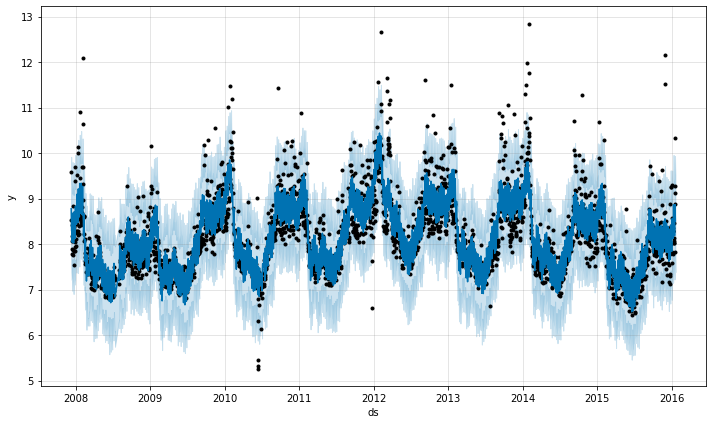

In [4]:
pred = predict_model(df)

In [5]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1 
    
    #changing -1 to 1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

In [6]:
pred = detect_anomalies(pred)

In [7]:
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2007-12-10,7.933895,8.777012,7.757950,9.917112,9.590761,0,0.0
1,2007-12-11,7.934140,8.509542,7.379781,9.570237,8.519590,0,0.0
2,2007-12-12,7.934385,8.294512,7.271429,9.411372,8.183677,0,0.0
3,2007-12-13,7.934630,8.272894,7.213803,9.325921,8.072467,0,0.0
4,2007-12-14,7.934874,8.276752,7.259052,9.426628,7.893572,0,0.0


In [8]:
filterDf = pred[pred['anomaly']!=0]

In [9]:
filterDf.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
20,2007-12-30,7.938792,8.497891,7.451306,9.552166,9.703145,1,0.015560
34,2008-01-13,7.942219,8.867188,7.792306,9.923873,9.996522,1,0.007267
42,2008-01-21,7.944178,9.331428,8.250362,10.403110,10.897202,1,0.045341
55,2008-02-04,7.947606,9.270614,8.323902,10.322595,12.097457,1,0.146714
56,2008-02-05,7.947850,8.966446,7.886185,10.002458,10.635278,1,0.059502


In [10]:
pred.dtypes

ds            datetime64[ns]
trend                float64
yhat                 float64
yhat_lower           float64
yhat_upper           float64
fact                 float64
anomaly                int64
importance           float64
dtype: object

In [11]:
pred=pred.set_index('ds')

In [12]:
pred.head()

,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
ds,,,,,,,
2007-12-10,7.933895,8.777012,7.757950,9.917112,9.590761,0,0.0
2007-12-11,7.934140,8.509542,7.379781,9.570237,8.519590,0,0.0
2007-12-12,7.934385,8.294512,7.271429,9.411372,8.183677,0,0.0
2007-12-13,7.934630,8.272894,7.213803,9.325921,8.072467,0,0.0
2007-12-14,7.934874,8.276752,7.259052,9.426628,7.893572,0,0.0


In [13]:
pred.index

DatetimeIndex(['2007-12-10', '2007-12-11', '2007-12-12', '2007-12-13',
               '2007-12-14', '2007-12-15', '2007-12-16', '2007-12-17',
               '2007-12-18', '2007-12-19',
               ...
               '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-15', '2016-01-16', '2016-01-17', '2016-01-18',
               '2016-01-19', '2016-01-20'],
              dtype='datetime64[ns]', name='ds', length=2905, freq=None)

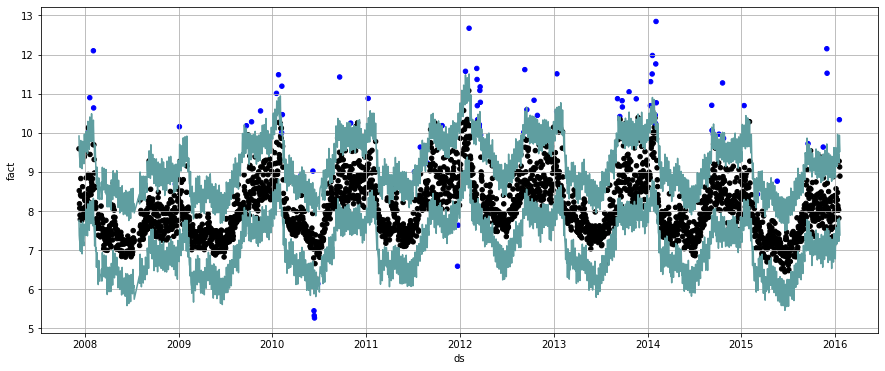

In [14]:
import numpy as np
colors = np.where(pred["anomaly"]==1,'blue','black')

pred.reset_index().plot(figsize=(15,6),kind='scatter',x = 'ds', y = 'fact',c=colors,colorbar=False)
plt.grid(True)
plt.plot(pred['yhat_lower'],label='yhat_lower',color='cadetblue')
plt.plot(pred['yhat_upper'],label='yhat_upper',color='cadetblue')
plt.show()